# Remote Timing Attacks are Practical
_Experiment 6: Attacking SSL applications on the local network._

---

In [1]:
import scipy
import scipy.signal
import seaborn
import sympy
import pandas
import os
import matplotlib.pyplot as plt

from IPython import display
from pprint import pprint

In [2]:
import tls
import attack

## Theory

In [3]:
p = sympy.Integer(11693128827090800677443535237632476895247105886644942164014088484470194179491435241190389270827811769965853291192455791684691555403909415703633832493911789)
q = sympy.Integer(11353860437120204348539420361367294927683441924641720282978666316144621735920188475867378638813811676070362003602263559496393696538309271007870774914687283)
N = sympy.Integer(132762152776056020551326919245624484615462467876809681535549565118332290525598572815747323476102181376625279228965473106140757139049665124368186142774966643990206422037551427526013151129106319233128471783533673959766053786798472937188481868923726256436384468384858420931063093337134977283618537887974322079287)

## Bruteforce Top Few Bits of $q$
The aim of this notebook is to sample the server response times for a bunch of `g` values, and find out if the distribution is meaningfully different between them.

In [4]:
NEIGHBOURHOOD_SIZE = 1600
SAMPLE_SIZE = 20
BRUTEFORCED_BITS = 5

filename = "./measurements/bruteforce-top-bits.txt"
if not os.path.exists(filename):
    gs = attack.bruteforce_most_significant_bits(num_bits=BRUTEFORCED_BITS)
    
    print("Taking {} samples...".format(len(gs)*SAMPLE_SIZE*NEIGHBOURHOOD_SIZE))
    
    raw_samples = attack.sample(
        gs,
        sample_size=SAMPLE_SIZE,
        neighbourhood_size=NEIGHBOURHOOD_SIZE,
        u_g=True,
        N=N,
    )
    samples = pandas.DataFrame.from_records(
        raw_samples,
        columns=["point", "time"],
    )
    samples.to_csv(filename, sep=" ")

else:
    samples = pandas.read_csv(
        filename,
        sep=" ",
        usecols=["point", "time"],
    )

samples['point'] = samples['point'].apply(sympy.Integer)
samples

,point,time
0,6703903964971298549787012499102923063739682910...,3848556
1,6703903964971298549787012499102923063739682910...,3703027
2,6703903964971298549787012499102923063739682910...,3775405
3,6703903964971298549787012499102923063739682910...,3705044
4,6703903964971298549787012499102923063739682910...,3706100
...,...,...
511995,1298881393213189094021233671701191343599563563...,3652114
511996,1298881393213189094021233671701191343599563563...,3583819
511997,1298881393213189094021233671701191343599563563...,3578774
511998,1298881393213189094021233671701191343599563563...,3651595


In the paper, they take median time for each point. By taking the minimum, I hope to extract the fastest time possible, which should be the time with minimal context switches and other delays. This works provided the only sources of unwanted noise _add time_ (rather than remove it).

In [5]:
samples = samples.groupby(by="point").median().reset_index()
samples

,point,time
0,6703903964971298549787012499102923063739682910...,3591313.0
1,6703903964971298549787012499102923063739682910...,3625458.0
2,6703903964971298549787012499102923063739682910...,3582157.0
3,6703903964971298549787012499102923063739682910...,3583097.0
4,6703903964971298549787012499102923063739682910...,3600799.5
...,...,...
25595,1298881393213189094021233671701191343599563563...,3579348.5
25596,1298881393213189094021233671701191343599563563...,3612218.0
25597,1298881393213189094021233671701191343599563563...,3583038.0
25598,1298881393213189094021233671701191343599563563...,3579891.0


We can group samples into their respective "neighbourhoods" considering their most significant bits only.

In [6]:
def point_to_neighbourhood(point):
    point_int = sympy.Integer(point)
    point_bits = attack.sympy_integer_to_bits(point_int)
    neighbourhood_point_bits = point_bits[0:BRUTEFORCED_BITS] + [0] * (512-BRUTEFORCED_BITS)
    neighbourhood_point_int = attack.bits_to_sympy_integer(neighbourhood_point_bits)
    return neighbourhood_point_int

samples['neighbourhood'] = samples['point'].apply(point_to_neighbourhood)

Sum together the measurements in each neighbourhood:

In [7]:
samples = samples.groupby(by="neighbourhood").mean().reset_index()
samples

,neighbourhood,time
0,6703903964971298549787012499102923063739682910...,3.588909e+06
1,7122897962782004709148700780296855755223413092...,3.586103e+06
2,7541891960592710868510389061490788446707143274...,3.585785e+06
3,7960885958403417027872077342684721138190873455...,3.587093e+06
4,8379879956214123187233765623878653829674603637...,3.587452e+06
5,8798873954024829346595453905072586521158333819...,3.588004e+06
6,9217867951835535505957142186266519212642064001...,3.586637e+06
7,9636861949646241665318830467460451904125794183...,3.586086e+06
8,1005585594745694782468051874865438459560952436...,3.587378e+06
9,1047484994526765398404220702984831728709325454...,3.586947e+06


Since we know the factors of `N` (`q` and `p` with `q<p`) we can consider each point relative in size to these factors. When plotting, we are looking for peaks and troughs near whole multples of `p` and `q`.

In [8]:
sqrt_N = sympy.sqrt(N)
samples['point_relative_to_sqrt_n'] = samples['neighbourhood'].apply(lambda g: round(float(g/sqrt_N), 10))
samples

,neighbourhood,time,point_relative_to_sqrt_n
0,6703903964971298549787012499102923063739682910...,3.588909e+06,0.581823
1,7122897962782004709148700780296855755223413092...,3.586103e+06,0.618187
2,7541891960592710868510389061490788446707143274...,3.585785e+06,0.654551
3,7960885958403417027872077342684721138190873455...,3.587093e+06,0.690914
4,8379879956214123187233765623878653829674603637...,3.587452e+06,0.727278
5,8798873954024829346595453905072586521158333819...,3.588004e+06,0.763642
6,9217867951835535505957142186266519212642064001...,3.586637e+06,0.800006
7,9636861949646241665318830467460451904125794183...,3.586086e+06,0.836370
8,1005585594745694782468051874865438459560952436...,3.587378e+06,0.872734
9,1047484994526765398404220702984831728709325454...,3.586947e+06,0.909098


In [9]:
q_relative_to_sqrt_n = round(float(q/sqrt_N), 10)
p_relative_to_sqrt_n = round(float(p/sqrt_N), 10)

Now plot the media response time as we vary `g`:

In [10]:
smallest_time_observed = samples['time'].min()
largest_time_observed = samples['time'].max()

buffer = (largest_time_observed - smallest_time_observed)/10

smallest_time_observed, largest_time_observed, buffer

(3584434.9721875, 3588909.3959375, 447.4423750000075)

In [11]:
if SAMPLE_SIZE == 20 and NEIGHBOURHOOD_SIZE == 800:
    error = 27442/(2*6529841)
elif SAMPLE_SIZE == 7 and NEIGHBOURHOOD_SIZE == 400:
    error = 42987/(2*6500856)
else:
    error = 0

In [12]:
ylim = (
    smallest_time_observed * (1 - error) - buffer,
    largest_time_observed * (1 + error) + buffer,
)

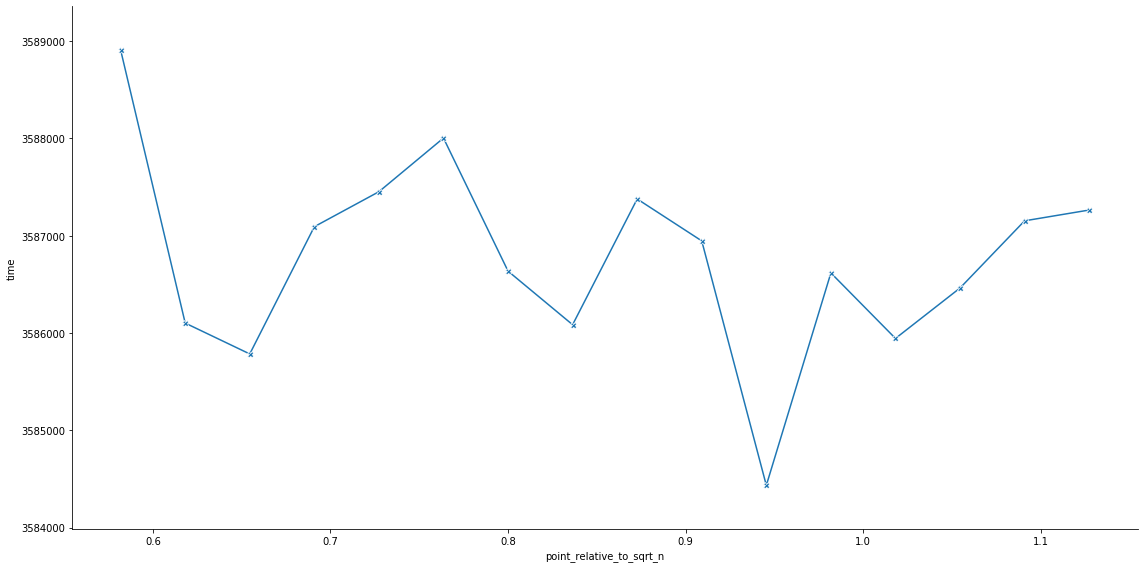

In [13]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")
if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g

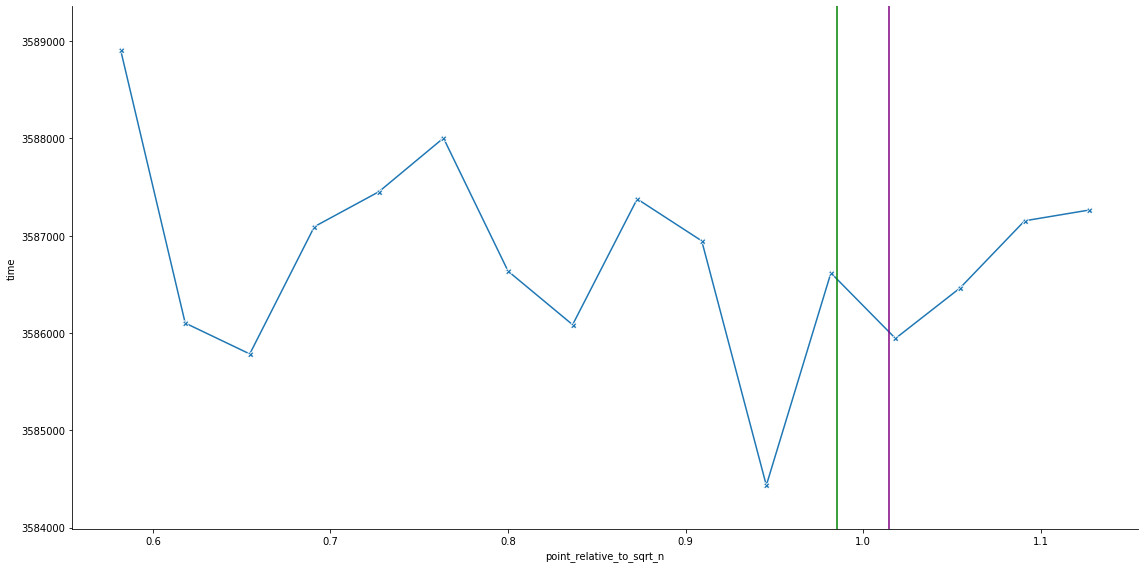

In [14]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='green')
plt.plot([p_relative_to_sqrt_n, p_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='purple')
if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g

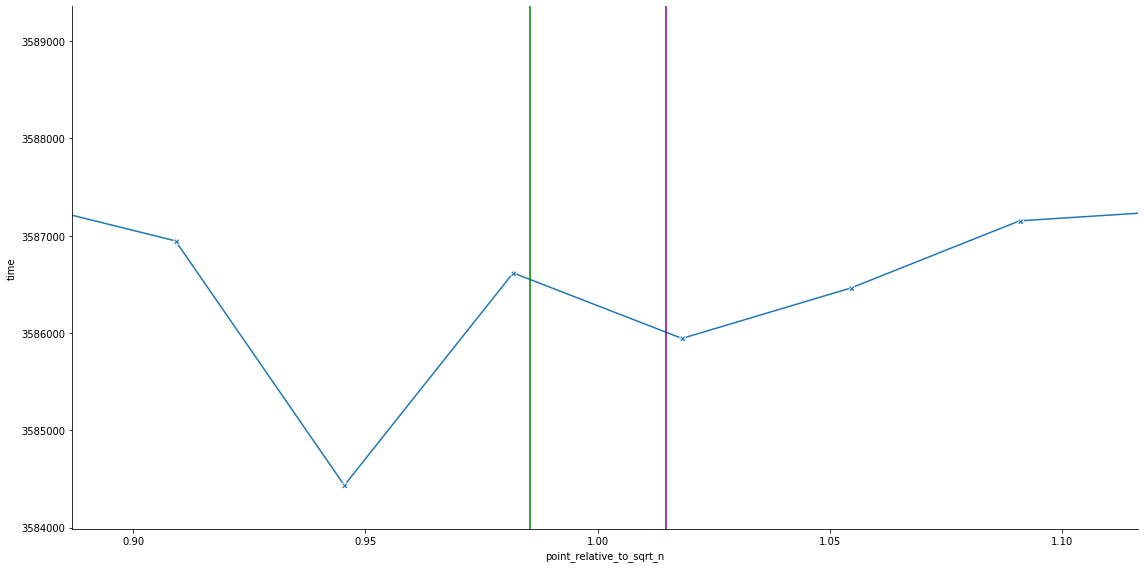

In [15]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='green')
plt.plot([p_relative_to_sqrt_n, p_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='purple')
if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g.set(xlim=(q_relative_to_sqrt_n*0.9, p_relative_to_sqrt_n*1.1))
g

In the section below, we bound the value of $q$ using the shape of this graph. But its worth noting that the peaks and troughs in the graphs above fit well inside the error bars (calculated in the `noise.ipynb` notebook). It is likely this graph should just be a straight line. 

### Bounding our search for `q`

`scipy` finds two peaks in the sample set.

In [16]:
peak_indices, _ = scipy.signal.find_peaks(samples['time'])
len(peak_indices)

3

Lets re-plot the above graph with the peaks highlighted:

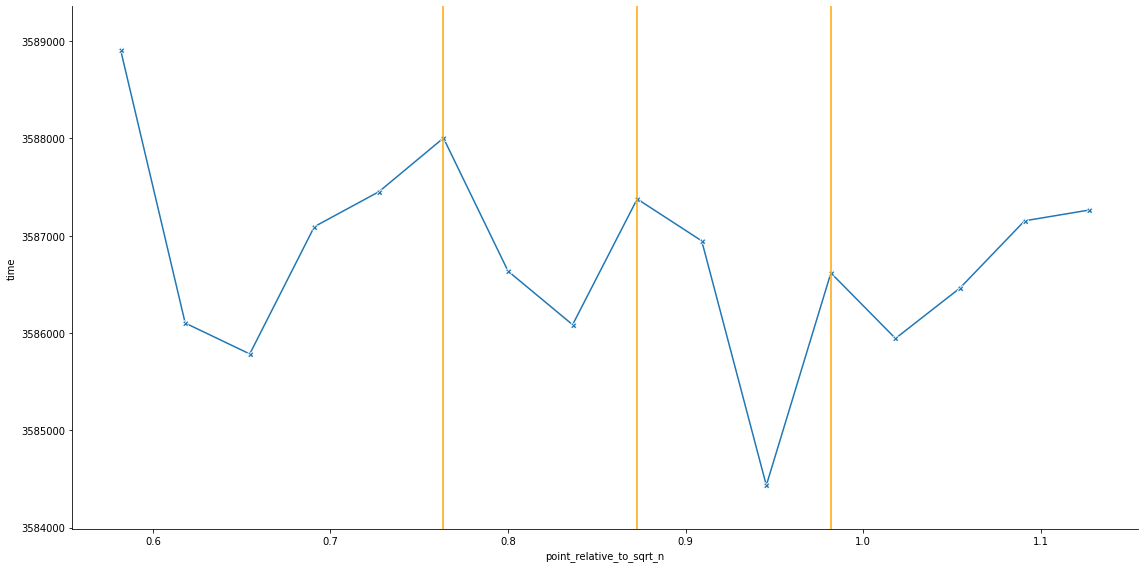

In [17]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")

for peak_index in peak_indices:
    peak = samples.iloc[peak_index]
    plt.plot([peak['point_relative_to_sqrt_n'], peak['point_relative_to_sqrt_n']], ylim, color='orange')

if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g

I'm going to cheat a little and say that: we should always pick the peak closest to, but less than, $\sqrt{N}$. Why? We are looking for the peak that gives a lower bound on $q$. After the peak, the number of Montgomery reductions should dip significantly. It will slowly rise until it hits $p$, where it will immediately dip significantly again. We know that $q < \sqrt{n} < p$, so there shouldn't be any peaks in the interval $(q, p)$. Therefore, the peak closest to, but less than, $\sqrt{N}$ is the peak caused by the dip in Montgomery  reductions when $g = q$.

In [42]:
for peak_index in peak_indices:
    peak_row = samples.iloc[peak_index]
    peak_g = peak_row['neighbourhood']
    
    if peak_g > sqrt_N:
        peak_index -= 1    
        peak_row = samples.iloc[peak+index]
        peak_g = peak_row['neighbourhood']
        break
        
peak_row

neighbourhood               1131283794088906630276558359223618267006071491...
time                                                              3.58662e+06
point_relative_to_sqrt_n                                             0.981826
Name: 11, dtype: object

In [37]:
attack.sympy_integer_to_bits(peak_g)[0:BRUTEFORCED_BITS]

[1, 1, 0, 1, 1]

This gives a lower bound on `q`. To get an upper bound on `q`, note the following:
  1. $q*p = N$
  2. $q < p$

From 1. and 2. it follows that $q < \sqrt{N}$.

(Suppose $q >= \sqrt{N}$, then by 2. $p > \sqrt{N}$ and so $ q*p > N$ which contradicts 1. Therefore $q < \sqrt{N}$.)

In [38]:
lower_bound = peak_g
upper_bound = sympy.Integer(sqrt_N.round())

lower_bound, upper_bound

(11312837940889066302765583592236182670060714911124831912454254968140238400374555261676581439078324767113464380344847605407854838622579918392303391348883456,
 11522245995293453226444537667133610590574234209345464522156603069988519317090416103523895551843843150180734266788088596830720220822331432054108383719953516)

Let's plot these two bounds on the graph:

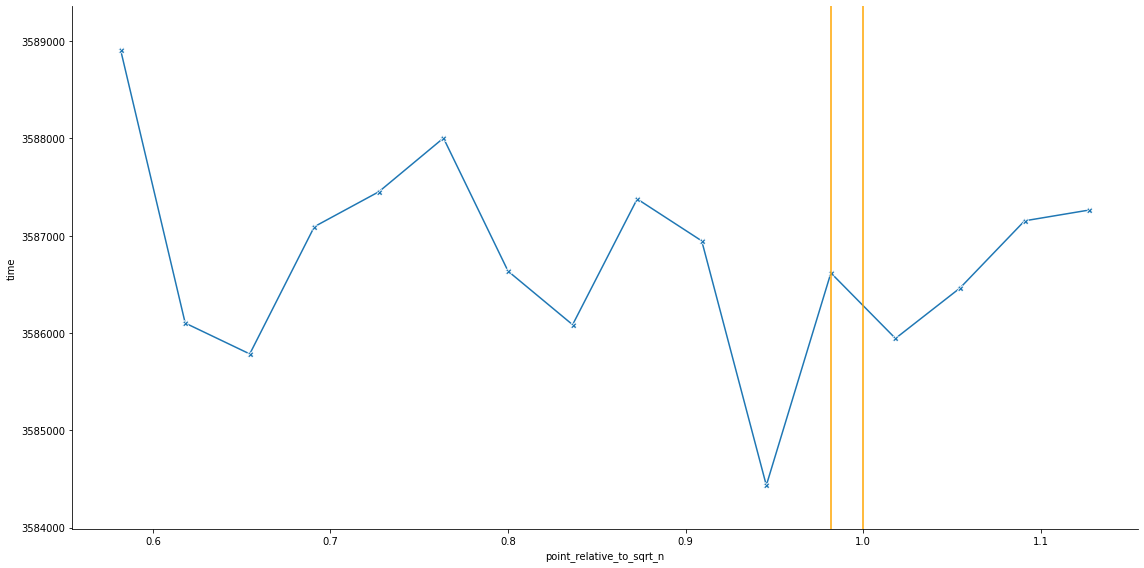

In [39]:
lower_bound_relative_to_sqrt_n = round(float(lower_bound/sqrt_N), 10)
upper_bound_relative_to_sqrt_n = round(float(upper_bound/sqrt_N), 10)

g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")

plt.plot([lower_bound_relative_to_sqrt_n, lower_bound_relative_to_sqrt_n], ylim, color='orange')
plt.plot([upper_bound_relative_to_sqrt_n, upper_bound_relative_to_sqrt_n], ylim, color='orange')

if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g

Lets consider the bit representations of these two bounds so we can set in stone the first few bits.

In [40]:
print("Lower Bound:", attack.sympy_integer_to_bits(lower_bound)[0:BRUTEFORCED_BITS])
print("Upper Bound:", attack.sympy_integer_to_bits(upper_bound)[0:BRUTEFORCED_BITS])

Lower Bound: [1, 1, 0, 1, 1]
Upper Bound: [1, 1, 0, 1, 1]


In [41]:
lower_bound_bits = attack.sympy_integer_to_bits(lower_bound)
upper_bound_bits = attack.sympy_integer_to_bits(upper_bound)

known_q_bits = []
for i in range(BRUTEFORCED_BITS):
    if lower_bound_bits[i] == upper_bound_bits[i]:
        known_q_bits.append(lower_bound_bits[i])
    else:
        break
        
known_q_bits

[1, 1, 0, 1, 1]

The above giving us the first bits of $q$.

Since it is prime, we also know that $q$ is odd, and so its least significant bit is 1. We'll ignore that for now.

# Recovering Bits of $q$

Run the iterative key recovery attack on bits 1, 2, and 3. We already know their true values, so there zero-one gaps can be used as reference points for the other bits.

In [6]:
BITS_TO_RECOVER = 100

In [7]:
q_bits = attack.sympy_integer_to_bits(q)

In [9]:
bit_samples_filename = "./measurements/bit-samples.txt"
bit_samples = pandas.DataFrame({
    'bit_position': [],
    'bit_value': [],
    'point': [],
    'time': [],
})

In [27]:
bits = []
for i in range(0, 4):
    print(i)
    
    g_low_samples, g_high_samples = attack.sample_ith_bit(
        q_bits,
        i,
        sample_size=SAMPLE_SIZE,
        neighbourhood_size=NEIGHBOURHOOD_SIZE,
    )
        
    g_low_samples['bit_position'] = i
    g_low_samples['bit_value'] = 0
    
    g_high_samples['bit_position'] = i
    g_high_samples['bit_value'] = 1
    
    bit_samples = pandas.concat([bit_samples, g_low_samples, g_high_samples], axis=0, sort=True)
    
bit_samples.to_csv(bit_samples_filename, sep=" ")

0
1
2
3


In [28]:
# @DAN: Plot the distributions like I did with the bruteforcing back in the day?

There's a reasonable midpoint which could be used to separate the zeroes from the ones above. So lets continue and see what we get. Note that from here onwards, I've used the _correct_ bits of q, not the one the algorithm has picked, so there is a little cheating going on in the below.

In [ ]:
for i in range(4, BITS_TO_RECOVER):
    print(i)
    
    g_low_samples, g_high_samples = attack.sample_ith_bit(
        q_bits,
        i,
        sample_size=SAMPLE_SIZE,
        neighbourhood_size=NEIGHBOURHOOD_SIZE,
    )
        
    g_low_samples['bit_position'] = i
    g_low_samples['bit_value'] = 0
    
    g_high_samples['bit_position'] = i
    g_high_samples['bit_value'] = 1
    
    bit_samples = pandas.concat([bit_samples, g_low_samples, g_high_samples], axis=0, sort=True)
    
    if i%5 == 0:
        bit_samples.to_csv(bit_samples_filename, sep=" ")

bit_samples.to_csv(bit_samples_filename, sep=" ")

In [12]:
bit_samples = pandas.read_csv(bit_samples_filename, sep=" ").drop("Unnamed: 0", axis=1)
bit_samples

,bit_position,bit_value,point,time
0,0.0,0.0,0,659238.0
1,0.0,0.0,1,3816809.0
2,0.0,0.0,2,3882911.0
3,0.0,0.0,3,3839911.0
4,0.0,0.0,4,3809069.0
...,...,...,...,...
6399995,99.0,1.0,1135386043712020434853942036135977879368661395...,3588344.0
6399996,99.0,1.0,1135386043712020434853942036135977879368661395...,3581249.0
6399997,99.0,1.0,1135386043712020434853942036135977879368661395...,3665748.0
6399998,99.0,1.0,1135386043712020434853942036135977879368661395...,3645503.0


Next, collate the sample sets and neughbourhoods to provide a single measurement for each bit position and value combination.

In [16]:
bit_timings = bit_samples\
    .groupby(["bit_position", "bit_value", "point"]).median()\
    .groupby(["bit_position", "bit_value"]).mean()\
    .reset_index()

bit_timings

,bit_position,bit_value,time
0,0.0,0.0,3.587081e+06
1,0.0,1.0,3.588675e+06
2,1.0,0.0,3.587605e+06
3,1.0,1.0,3.588301e+06
4,2.0,0.0,3.587818e+06
...,...,...,...
195,97.0,1.0,3.588056e+06
196,98.0,0.0,3.589364e+06
197,98.0,1.0,3.594862e+06
198,99.0,0.0,3.587579e+06


To replicate the paper, we calculate the zero-one gap for each bit position:

In [26]:
def calc_zero_one_gap(row):
    T_g_low = row[row['bit_value']==0]['time'].iloc[0]
    T_g_high = row[row['bit_value']==1]['time'].iloc[0]
    return abs(T_g_low-T_g_high)

zero_one_gaps = bit_timings.groupby("bit_position").apply(calc_zero_one_gap)
zero_one_gaps[0:10]

bit_position
0.0     1593.823125
1.0      696.594063
2.0      123.769687
3.0     3126.372188
4.0     1305.570312
5.0       83.539687
6.0       95.227500
7.0     7916.380312
8.0      850.309063
9.0      959.875000
10.0     962.936562
dtype: float64

Plot the gap for each bit position, with a color to denote its true value. Can we separate these into two distinct distributions?

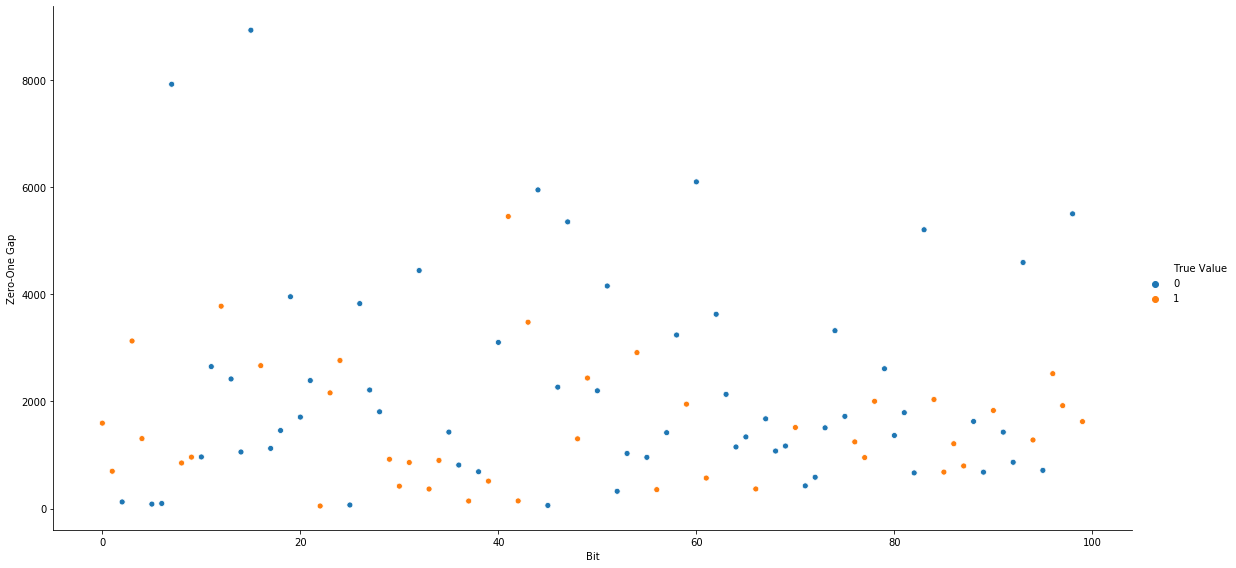

In [27]:
seaborn.relplot(
    data=pandas.DataFrame({
        'True Value': q_bits[0:BITS_TO_RECOVER],
        'Zero-One Gap': zero_one_gaps,
        'Bit': range(0, BITS_TO_RECOVER),
    }),
    x='Bit',
    y='Zero-One Gap',
    hue='True Value',
    kind='scatter',
    height=8,
    aspect=16/8,
)

No midpoint exists which allows us to separate the two groups. Intuitively, it looks like they come from the same distribution.

Further, even the highest zero-one gap is around 9000 cycles. That's only two to four times the range of values detected in the noise notebook. This indicates either the error is too high, the zero-one gap is too small, or no zero-one gap exists.

Given the lack of peaks and troughs during the bruteforce stage, it looks like we aren't detecting any relationship between the input points `g` and the decryption time. 

The exception might be previous runs where we included `q` and `p` as inputs. In those clear and consistent dips could be found at the exact `p` and `q` points only.

The evidence in this notebook suggests that the server isn't vulnerable to this attack.

Possible issues I can think of:
  1. Using a newer `gcc` modified the implementation such that this timing attack doesn't work anymore.
  2. Noise from Docker/network stack.
  3. Incorrect configuration of Apache + OpenSSL + `mod_ssl`.
  4. Implementation of the actual attack is incorrect. I think this is the most likely issue.
  
Potential solves:
  1. I started work on using gcc 2.9.6 (can be seen in the git history) but it was a hassle so I want avoid it for now. Further, these results were run against an OpenSSL compiled with optimisations turned off. I believe this is unlikely to be the primary cause of the issue.
  2. Noise isn't the issue: we've measured the noise in the [noise notebook](noise.ipynb) and it isn't the issue.
  3. Not sure how to solve this. Check documentation and installation scripts to ensure blinding isn't enabled.
  4. I have found one other implementation of the attack code on GitHub. Run there attack against my server and plot the results. Do we get a good curve? Then the problem is with my attack, otherwise it's with the server (and possibly the attack as well). Compare the code and see how they differ.

A potential improvement, though I don't think it will solve the overall problem, is to downclock the core running the server, while keeping the core of the attacking client at maximum. This will increase the relative accuracy of our timing measurements.
  

#### Examining the relationship between neighbourhood size and zero-one gap

Another option for distinguishing individual bits is to examine how the zero-one gap changes as we increase the neighbourhood size. In the paper, they take the sum over each neighbourhood to calculate $T_{g_{lo}}$ and $T_{g_{hi}}$. And they expect the zero-one gap to increase as the neighbourhood size increases for 0 bits. However, in this notebook w've been taking the mean over each neighbourhood. So we should, instead, look for the the 1 bits to approach 0 as the neighbourhood size increases. Let's see.

In [53]:
df = {
    'Neighbourhood Size': [],
    'Zero Gap': [],
    'One Gap': [],
}

for neighbourhood_size in range(1, 1602, 50):
    sample_sets = bit_samples.groupby(["bit_position", "bit_value", "point"]).median()
    neighbourhoods = sample_sets.groupby(["bit_position", "bit_value"]).head(neighbourhood_size)
    bit_timings = neighbourhoods.groupby(["bit_position", "bit_value"]).mean().reset_index()
    
    zero_one_gaps = bit_timings.groupby("bit_position").apply(calc_zero_one_gap)
    
    zero_gaps = []
    one_gaps = []
    for bit_position in range(BITS_TO_RECOVER):
        if q_bits[bit_position] == 0:
            zero_gaps.append(zero_one_gaps[bit_position])
        elif q_bits[bit_position] == 1:
            one_gaps.append(zero_one_gaps[bit_position])
    
    zero_gaps = pandas.Series(zero_gaps)
    one_gaps = pandas.Series(one_gaps)
    
    df['Neighbourhood Size'].append(neighbourhood_size)
    df['Zero Gap'].append(zero_gaps.mean())
    df['One Gap'].append(one_gaps.mean())
    
df = pandas.DataFrame(df)
df

,Neighbourhood Size,Zero Gap,One Gap
0,1,19759.279661,88540.329268
1,51,5901.747258,5285.220230
2,101,5098.251888,4303.467761
3,151,4574.230329,3866.196333
4,201,4286.988869,3493.116066
5,251,3942.409548,3113.420659
6,301,3865.746410,3122.131310
7,351,3917.410015,3129.494337
8,401,3822.559407,3043.946749
9,451,3640.962832,2968.594911


With the exception of `neighbourhood_size=1`, the average one gap is always less than the average zero gap. This is a good sign, I think. It shows that the gaps display the behaviour we need as a population, even though the individual variance is too high to identify indivudal bits.

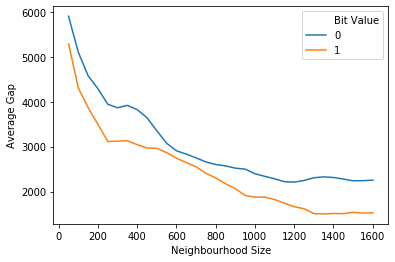

In [56]:
df_plot = {
    'Neighbourhood Size': [],
    'Average Gap': [],
    'Bit Value': [],
}

for _, row in df[df['Neighbourhood Size'] != 1].iterrows():
    df_plot['Neighbourhood Size'].append(row['Neighbourhood Size'])
    df_plot['Average Gap'].append(row['Zero Gap'])
    df_plot['Bit Value'].append(0)
    
    df_plot['Neighbourhood Size'].append(row['Neighbourhood Size'])
    df_plot['Average Gap'].append(row['One Gap'])
    df_plot['Bit Value'].append(1)


seaborn.lineplot(data=pandas.DataFrame(df_plot), x='Neighbourhood Size', y='Average Gap', hue='Bit Value')

Increasing the neighbourhood size decreases average gap for both zero bits and one bits. Further, it doesn't seem to have increased the distance between te average gaps. 

In [55]:
df['Zero Gap'][1:].mean(), df['One Gap'][1:].mean()

(3014.622947700105, 2442.2953081129563)

## Coppersmiths Attack

## References
  - [1] https://crypto.stanford.edu/~dabo/papers/ssl-timing.pdf